In [1]:
###########import packages##########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn.linear_model import BayesianRidge
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import ExtraTreeClassifier
from sklearn import linear_model
import lightgbm
import catboost
import xgboost
import shap
#import seaborn as sns
from catboost import *
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score
#%matplotlib
def compute_mae_mse_rmse(target,prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)  # target-prediction之差平方
        absError.append(abs(val))  # 误差绝对值
    mae=sum(absError)/len(absError)  # 平均绝对误差MAE
    mse=sum(squaredError)/len(squaredError)  # 均方误差MSE
    RMSE=np.sqrt(sum(squaredError)/len(squaredError))
    R2=r2_score(target,prediction)
    return mae,mse,RMSE,R2
###########loading data##########
fdata=pd.read_csv('database_filled_ST.csv',encoding="gbk")
raw_data=fdata.loc[:,[
                      'Operating Temperature (℃)',#0
                      'Flow Rate (mL min-1)',#1
                      'Active Area (cm2)', #2
                      'Ir wt. %',#3
                      'Ru wt.%',#4
                      'O wt. %',#5
                      'I/C in Anode',#6
                      'Pt wt. %',#7
                      'I/C in Cathode',#8 
                      'Anode Precious Metal Loading (mg cm-2 Ir/Ru/Pt/Pd)',#9
                      'Cathode Precious Metal Loading (mg cm-2 Pt/Pd)',#10
                      'Membrane Thickness (μm)',#11
                      'EW',#12
                      'Maximum Stability Current Density (A cm-2)',#13
                      'Stability Test Time (h-1)'#14
                        ]]
###########train test splitting##########
raw_param=raw_data.iloc[:,0:15]
print('ready')


ready


In [2]:
DR=fdata.loc[:,['logDR']].values

In [3]:
def summarize(list1):
    total=0
    for ele in range(0, len(list1)):
        total = total + list1[ele]
    return total

In [4]:
def gridsearch(model,param,algorithm_name):
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-1)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    result = best_model.predict(X_test)
    x_prediction_07=result
    y_real_07=y_test[:,0]
    x_prediction_07_series=pd.Series(x_prediction_07)
    y_real_07_series=pd.Series(y_real_07)
    
    result_train = best_model.predict(X_train)
    x_prediction_07_train=result_train
    y_real_07_train=y_train[:,0]
    x_prediction_07_series_train=pd.Series(x_prediction_07_train)
    y_real_07_series_train=pd.Series(y_real_07_train)
    
    ###########evaluating the regression quality##########
    corr_ann = round(x_prediction_07_series.corr(y_real_07_series), 5)
    error_val= compute_mae_mse_rmse(x_prediction_07,y_real_07)
    
    corr_ann_train = round(x_prediction_07_series_train.corr(y_real_07_series_train), 5)
    error_val_train= compute_mae_mse_rmse(x_prediction_07_train,y_real_07_train)
    
    print(algorithm_name)
    print(best_model.feature_importances_)
    print('Best Regressor:',grid.best_params_,'Best Score:', grid.best_score_)
    print(error_val,'TEST R2',error_val[3],'TEST CORR',corr_ann)
    print(error_val_train,'TRAIN R2',error_val_train[3],'TRAIN CORR',corr_ann_train)
    x_y_x=np.arange(0,5,0.1)
    x_y_y=np.arange(0,5,0.1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x_prediction_07,y_real_07,color='red',label=algorithm_name+' Test Set',alpha=0.75)
    ax.scatter(x_prediction_07_train,y_real_07_train,color='blue',label=algorithm_name+' Training Set',alpha=0.25,marker="^")
    ax.plot(x_y_x,x_y_y)
    plt.legend()
    plt.xlabel(u"Predicted_Log(Decay Rate(μV h-1))")
    plt.ylabel(u"Real_Log(Decay Rate(μV h-1))")
    plt.savefig('DR SEL %s.png' %algorithm_name)
    print('finished')
    return best_model

In [5]:
seed= 1686
X_train, X_test, y_train, y_test = train_test_split(raw_param, DR, test_size=.15,random_state=seed)

In [6]:
from catboost import *
import shap
def shap_plot(model,param,algorithm_name):
    print(algorithm_name)
    SHAP_INPUT=raw_data.iloc[:,0:15]
    SHAP_OUTPUT=DR
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-100)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    X_SHAP=SHAP_INPUT.values.astype(np.float32)
    y_SHAP=SHAP_OUTPUT
    if algorithm_name=='CatBoost':
        shap_values = best_model.get_feature_importance(Pool(X_SHAP,y_SHAP), type="ShapValues")
        shap_values=shap_values[:,:-1]
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    elif algorithm_name=='Random Forest' or algorithm_name=='Extra Tree'or algorithm_name=='Decision Tree'or algorithm_name=='AdaBoost':
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    else:
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)

In [7]:
def shap_plot_interaction(best_model,algorithm_name,interacted_features):
    print(algorithm_name)
    SHAP_INPUT=raw_param
    SHAP_OUTPUT=DR
    print('train finished')
    X_SHAP=SHAP_INPUT.values.astype(np.float32)
    y_SHAP=SHAP_OUTPUT.astype(np.float32)

    if algorithm_name=='CatBoost':
        shap_values = best_model.get_feature_importance(Pool(X_SHAP,y_SHAP), type="ShapValues")
        shap_values=shap_values[:,:-1]
        shap.dependence_plot(interacted_features[0], shap_values, SHAP_INPUT,interaction_index= interacted_features[1])
        shap.dependence_plot(interacted_features[1], shap_values, SHAP_INPUT,interaction_index= interacted_features[0])
    elif algorithm_name=='Random Forest' or algorithm_name=='Extra Tree'or algorithm_name=='Decision Tree'or algorithm_name=='AdaBoost':
        explainer = shap.TreeExplainer(best_model,SHAP_INPUT)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)        
        interaction_values = shap.TreeExplainer(best_model).shap_interaction_values(SHAP_INPUT) 
        print(shap_values)
        shap.dependence_plot(interacted_features[0], shap_values, SHAP_INPUT,interaction_index= interacted_features[1])
        shap.dependence_plot(interacted_features[1], shap_values, SHAP_INPUT,interaction_index= interacted_features[0])
    elif algorithm_name=='ANN':
        SHAP_INPUT=standardized_data.iloc[:,0:22]
        SHAP_OUTPUT=raw_data.iloc[:,22]
        X_SHAP=SHAP_INPUT.values.astype(np.float32)
        y_SHAP=SHAP_OUTPUT.values.astype(np.float32)
        explainer = shap.DeepExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP) 
        print(shap_values)
        shap.dependence_plot(interacted_features[0], shap_values[0], SHAP_INPUT,interaction_index= interacted_features[1])
        shap.dependence_plot(interacted_features[1], shap_values[0], SHAP_INPUT,interaction_index= interacted_features[0])
    else:
        explainer = shap.TreeExplainer(best_model,SHAP_INPUT)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        interaction_values = shap.TreeExplainer(best_model).shap_interaction_values(SHAP_INPUT)
        shap.dependence_plot(interacted_features[0], shap_values, SHAP_INPUT,interaction_index= interacted_features[1])
        shap.dependence_plot(interacted_features[1], shap_values, SHAP_INPUT,interaction_index= interacted_features[0])
from pdpbox import pdp
def plot_pdp_interact_ANN(model, df, f_list, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    inter1 = pdp.pdp_interact(model, df, model_features=df.columns.tolist(), features=f_list,num_grid_points=[20,20])
    # plot it
    settings = {
            'contour_color':  'white',
            'font_family': 'Arial',
            # matplotlib color map for interact plot
            'cmap': 'viridis',
            # fill alpha for interact plot
            'inter_fill_alpha': 0.8,
            # fontsize for interact plot text
            'inter_fontsize': 7,
        }
    pdp.pdp_interact_plot(
    pdp_interact_out=inter1, feature_names=f_list, plot_type='contour',figsize=(10,10),x_quantile=True, plot_pdp=True,plot_params=settings)
from sklearn.inspection import plot_partial_dependence
from sklearn.utils import validation
def pdp_plot_2d(best_model,f_list):
    print('start')
    validation.check_is_fitted(estimator=best_model)
    my_plots =plot_partial_dependence(best_model, features=[f_list], X=raw_param, percentiles=(0, 1),grid_resolution=100,target=0)
def pdp_plot_2d_XG_CAT(best_model,f_list):
    print('start')
    best_model.dummy_ = "dummy"
    validation.check_is_fitted(estimator=best_model)
    my_plots =plot_partial_dependence(best_model, features=[f_list], X=raw_param, percentiles=(0, 1),grid_resolution=100,target=0)
def pdp_plot_2d_ANN(model,f_list):
    print('start')
    model.dummy_ = "dummy"
    print(type(model))
    validation.check_is_fitted(estimator=model)
    my_plots =plot_partial_dependence(model, features=[f_listt], X=raw_input, percentiles=(0, 1))

XGBoost
[0.01191314 0.02487898 0.19678505 0.05210716 0.01168877 0.17417645
 0.07979202 0.02799346 0.06338507 0.06297662 0.06090068 0.04531766
 0.03006596 0.03617569 0.12184319]
Best Regressor: {'booster': 'gbtree', 'learning_rate': 0.15, 'max_depth': 13, 'n_estimators': 200, 'reg_alpha': 0.0001, 'reg_lambda': 0.001, 'subsample': 0.55} Best Score: 0.48777467502927196
(0.22115186209064813, 0.08199583484538508, 0.28634914849774756, 0.9145568321974602) TEST R2 0.9145568321974602 TEST CORR 0.96227
(0.012850000644762449, 0.0031365805057806556, 0.056005182847488816, 0.9970801954640574) TRAIN R2 0.9970801954640574 TRAIN CORR 0.99856
finished


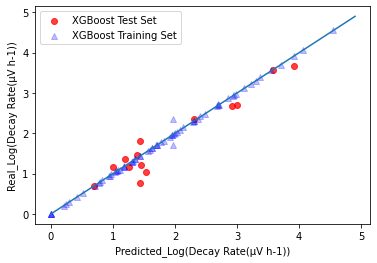

In [8]:
##########XGBoost gridsearch CV for best hyperparameter##########
model_XGBRegressor=xgboost.XGBRegressor(objective='reg:squarederror',random_state=1,verbosity=0)
param_xg = {
'booster':['gbtree'],
'learning_rate':[0.15],
'n_estimators':[200],
'max_depth':[13],
'subsample':[0.55],
'reg_alpha':[0.0001],
'reg_lambda':[0.001]
}
XG=gridsearch(model_XGBRegressor,param_xg,'XGBoost')

In [17]:
%matplotlib
inter_feature_list=[['Ir wt. %','Ru wt.%'],["Cathode Precious Metal Loading (mg cm-2 Pt/Pd)","I/C in Cathode"],['Anode Precious Metal Loading (mg cm-2 Ir/Ru/Pt/Pd)','I/C in Anode'],['Membrane Thickness (μm)','EW'],['Stability Test Time (h-1)','Maximum Stability Current Density (A cm-2)']]

Using matplotlib backend: Qt5Agg


In [18]:
for inter_feature in inter_feature_list:
    shap_plot_interaction(XG,algorithm_name="XGBoost",interacted_features=inter_feature)

XGBoost
train finished
XGBoost
train finished
XGBoost
train finished
XGBoost
train finished
XGBoost
train finished


In [19]:
for inter_feature in inter_feature_list:
    pdp_plot_2d_XG_CAT(XG,inter_feature)

start
start
start
start
start
